# Cross-correlation of Okhotsk 2013 late coda
## Core phases constructed from cross-correlations of 2013 Okhotsk earthquake reverberations confirm directionality of late coda waves

This notebook demonstrates data analysis for a poster presented at a conference in 2016. The analysis is done with ObsPy and uses the HDF5 read/write plugin [obspyh5](https://github.com/trichter/obspyh5).

If you want to run this notebook locally, have a look at the repository [readme](https://github.com/trichter/notebooks).
Dependencies of this notebook are ObsPy, h5py, obspyh5, and tqdm.

**Reference**: Tom Eulenfeld (2016), Core phases constructed from cross-correlations of 2013 Okhotsk earthquake reverberations confirm directionality of late coda waves, doi: [10.6084/m9.figshare.2074702](http://dx.doi.org/10.6084/m9.figshare.2074702).

## Introduction

Ambient noise can be used to construct surface waves by cross-correlation of continuous data between two stations. The cross-correlation basically filters all waves traveling from one station to the other. One station can be considered as a virtual source, the other station as virtual receiver. 

Because noise sources mostly stimulate surface waves it is difficult to construct body waves from cross-correlation of ambient noise. However, it is possible to use the coda of earthquakes as a "noise" source stimulating body waves, too. Here, we analyze such a coda wave field of a large deep-ruptured earthquake which effectively stimulated body waves traveling through the Earth.

## Hands on...

10 hours of data from world-wide broad-band stations starting with the origin time of the 2013 Okhotsk (Mw 8.3) event were obtained from GeoFon with the ObsPy ArcLink client. Data were bandpassed between 0.05 Hz and 0.1 Hz and downsampled to 1 Hz. In the following, a HDF5 file containing the preprocessed data is downloaded. The file is read in with ObsPy and the obspyh5 plugin. Some basic information is plotted.

In [1]:
from obspy import read
import os.path
from tqdm import tqdm
import urllib.request

def hook(t):
    """Hook for displaying the download progressbar"""
    last_b = [0]
    def inner(b=1, bsize=1, tsize=None):
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b
    return inner

# Download the data
datadir = os.path.join('data', '')
fname = 'okhotsk_data.h5'
url = 'https://github.com/trichter/misc/raw/master/data/'
if not os.path.exists(fname):
    with tqdm(unit='B', unit_scale=True, desc=fname) as t:
        urllib.request.urlretrieve(url + fname, datadir + fname, reporthook=hook(t))

# Read the three data files into single ObsPy Stream
stream = read(datadir + fname)
print(stream, '\n\n\nHeader of first trace:\n', stream[0].stats)

okhotsk_data.h5: 104MB [00:04, 23.9MB/s]                            


853 Trace(s) in Stream:

AI.BELA.04.BHZ | 2013-05-24T05:44:48.600000Z - 2013-05-24T15:44:48.600000Z | 1.0 Hz, 36001 samples
...
(851 other traces)
...
TW.YULB..BHZ | 2013-05-24T05:44:48.619500Z - 2013-05-24T15:44:48.619500Z | 1.0 Hz, 36001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces] 


Header of first trace:
          network: AI
         station: BELA
        location: 04
         channel: BHZ
       starttime: 2013-05-24T05:44:48.600000Z
         endtime: 2013-05-24T15:44:48.600000Z
   sampling_rate: 1.0
           delta: 1.0
            npts: 36001
           calib: 1.0
         _format: H5
             baz: 191.6679106
        distance: 156.695105528
       elevation: 262.0
        latitude: -77.875
       longitude: -34.6269


Data was collected from 853 stations with a sampling rate of 1 Hz. The HDF5 format has the advantage that it can store arbitrary header fields. Here, the metadata attached to the traces contains only station coordinates and the distance to the epicenter in degrees. First let us visualize station locations and the earthquake epicenter.

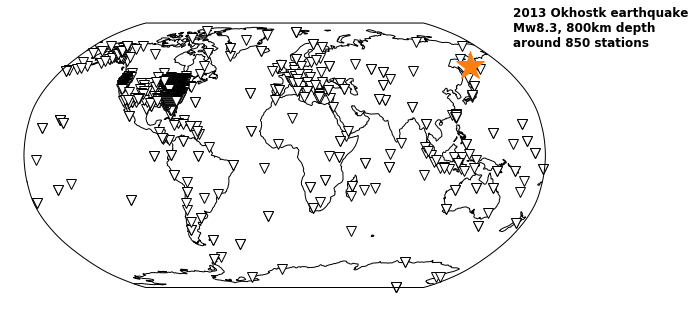

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def plot_map(cevent, cstations, label=None):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection=ccrs.Robinson())
    ax.coastlines()
    pc = ccrs.PlateCarree()
    ax.plot(*list(zip(*cstations))[::-1], 'v', mfc='w', mew=1, mec='k', ms=10, transform=pc)
    ax.plot(*cevent[::-1], '*', color='C1', ms=30, transform=pc)
    if label:
        ax.annotate(label, (0.9, 0.9), xycoords='axes fraction',
                     weight='bold', size='large')

cevent = [54.912, 153.339]  # latitude and longitude of epicenter
cstations = [(tr.stats.latitude, tr.stats.longitude) for tr in stream]
label = '2013 Okhostk earthquake\nMw8.3, 800km depth\naround 850 stations'
plot_map(cevent, cstations, label)
plt.show()


How does the data look? To get a first overview we want to produce a classical travel time plot of one hour of data. Because a lot of stations with similar distances to the event exist, waveforms will be stacked first. Here a stack over 0.5° distance bins is created and plotted with a patched version of the ObsPy Stream.plot method with keyword `type='section'`. The variable `wfstack` holds the stack of all traces; the `distance` header contains the mid point of the respective distance bin.

In [3]:
import numpy as np
from obspy import Trace, Stream

def stack_waveforms(stream, ddeg=0.5, fill_all_bins=True):
    """
    Stack waveforms in stream (iterator of Traces) in distance bins of ddeg° width.
    
    If fill_all_bins is true a Trace will be created for every distance bin.
    If no data is available in a bin it will be filled with zeros.
    """
    distbins = np.linspace(0, 180, int(round(180 / ddeg)), endpoint=False)
    stack = {}
    for tr in stream:
        ind = np.digitize(tr.stats.distance, distbins) - 1
        if ind not in stack:
            header = {'distance': distbins[ind] + 0.5 * ddeg, 'num': 1,
                      'sampling_rate': tr.stats.sampling_rate,
                      'starttime': tr.stats.starttime, 'ddeg': ddeg}
            stack[ind] = Trace(data=tr.data, header=header)
        else:
            tr2 = stack[ind]
            tr2.data = tr2.data + tr.data
            tr2.stats.num += 1
    for tr2 in stack.values():
        tr2.data = tr2.data / tr2.stats.num
    if fill_all_bins:
        header['num'] = 0
        nodata = np.zeros(len(tr))
        for ind in range(len(distbins)):
            if ind not in stack:
                header['distance'] = distbins[ind] + 0.5 * ddeg
                stack[ind] = Trace(data=nodata, header=header)
    return Stream(traces=stack.values())

# Slice into stream to stack only the first hour of data
wfstack = stack_waveforms(stream.slice(endtime=stream[0].stats.starttime + 3600), fill_all_bins=False)

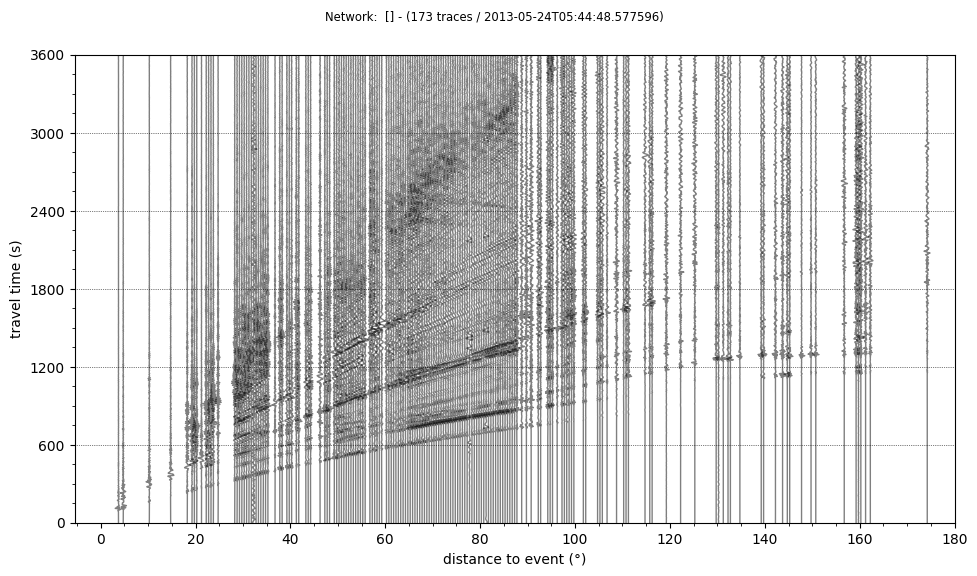

In [4]:
def plot_waveform_stack(stack):
    fig = stack.plot(type='section', norm='stream', offset_max=180, handle=True, scale=1)
    ax = fig.axes[0]
    degs = np.arange(10) * 20
    ax.set_xticks(degs / 180. * ax.get_xlim()[1])
    ax.set_xticklabels([str(d) for d in degs])   
    ax.set_xlabel(u'distance to event (°)')
    ax.set_yticks(np.arange(7) * 600)
    ax.set_ylabel('travel time (s)')

plot_waveform_stack(wfstack)
plt.show()

OK, this looks good. Visible are surface waves, the P wave, multiples, and core phases like PKP and PKIKP.

## Cross-correlation of the coda and stacking in distance bins

But actually we are interested in the coda. So, lets look at an individual waveform of a station located in Germany. The second plot shows a zoomed-in version.

IU.GRFO..BHZ


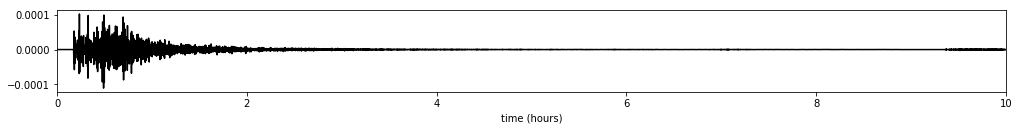

In [5]:
def plot_trace(tr, ylim=None, xcorr=False):
    fig = plt.figure(figsize=(17, 1.5))
    ax = fig.add_subplot(111)
    hours = tr.times() / 3600
    if xcorr:
        hours = hours - np.max(hours) / 2
    ax.plot(hours, tr.data, 'k')
    ax.set_xlabel('lag ' * xcorr + 'time (hours)')
    #ax.set_yticklabels([])
    if ylim:
        ax.set_ylim(ylim)

tr = stream.select(station='GRFO')[0]
print(tr.id)
plot_trace(tr)
plt.xlim(0, 10)
plt.show()

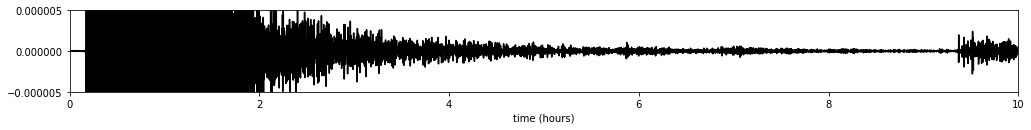

In [6]:
plot_trace(tr)
plt.xlim(0, 10)
plt.ylim(-5e-6, 5e-6)  # zoom in to see the late coda
plt.show()

We see a nice late coda which we want to use to construct body waves traveling between station pairs. Arrivals of the Mw 6.7 [supershear](http://dx.doi.org/10.1126/science.1252717) aftershock rupturing around 9 hours after the main shock are visible, too. The time window which will be used for the cross-correlation spans from 10000 to 30000 seconds after the main shock (3.7 to 8.3 hours). We normalize data by dividing through the running mean (of absolute data) over 300 seconds to guarantee equal contribution of early and late parts in the coda. The normalized waveform of the data example above is produced in the following.

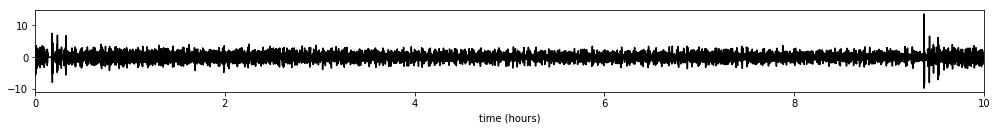

In [7]:
def normalize(tr, window=300):
    w = np.ones(int(window * tr.stats.sampling_rate), 'd')
    smoothed = np.convolve(w / np.sum(w), np.abs(tr.data), mode='same')
    tr.data = tr.data / smoothed
    return tr

normalized_tr = normalize(tr.copy())
plot_trace(normalized_tr)
plt.xlim(0, 10)
plt.show()

Now, we normalize all available data and cut out the late coda.

In [8]:
def prepare(tr, rm_window=300, trim_window=(10000, 30000)):
    tr.detrend('linear')
    normalize(tr, window=rm_window)
    t = tr.stats.starttime
    tr.trim(t + trim_window[0], t + trim_window[1])

pstream = stream.copy()  # Stream with prepared data
for tr in pstream:
    prepare(tr)

Three cross-correlation functions are defined acting on different input parameters:

* `xcorr` calculates the corss-correlation of two arrays by multiplication in the Fourier domain,
* `xcorr_traces` correlates two traces and inserts appropriate metadata (e.g. inter-station distance) and
* `xcorr_iter` correlates all traces inside the passed stream. It returns an iterator, so correlated traces can be processed one after the other. This has the advantage that not all of the large number of cross-correlation have to be held in memory at the same time. (The `tqdm` function of the same module is used to print a nice progress bar. It can be ignored when going through the code.)

The cross-correlation is calculated and plotted for two selected stations.

Cross-correlation between stations CU.GRGR.IU.GRFO


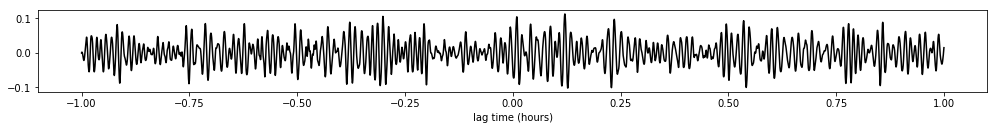

In [9]:
from itertools import combinations
from obspy.geodetics import gps2dist_azimuth
from obspy.signal.cross_correlation import correlate

def xcorr_traces(tr1, tr2, maxshift=3600):
    n1, s1, l1, c1 = tr1.id.split('.')
    n2, s2, l2, c2 = tr2.id.split('.')
    sr = tr1.stats.sampling_rate
    gps_args = (tr1.stats.latitude, tr1.stats.longitude, tr2.stats.latitude, tr2.stats.longitude)
    dist = gps2dist_azimuth(*gps_args)[0] / 1000 / 111.2
    xdata = correlate(tr1.data, tr2.data, int(round(maxshift * sr)))
    header = {'network': n1, 'station': s1, 'location': n2, 'channel': s2,
              'network1': n1, 'station1': s1, 'location1': l1, 'channel1': c1,
              'network2': n2, 'station2': s2, 'location2': l2, 'channel2': c2,
              'sampling_rate': sr, 'distance': dist}
    return Trace(data=xdata, header=header)

def xcorr_iter(stream, disable_tqdm=False):
    total = (len(stream) * (len(stream) - 1)) // 2
    for tr1, tr2 in tqdm(combinations(stream, 2), total=total, disable=disable_tqdm):
        yield xcorr_traces(tr1, tr2)

for tr in xcorr_iter(pstream.select(station='GR[FG]?'), disable_tqdm=True):
    print('Cross-correlation between stations', tr.id)
    plot_trace(tr, xcorr=True)
plt.show()

Now comes the sugar. All cross-correlations are calculated and stacked in distance bins on the fly. We reuse the stacking function defined for the "real" arrivals. The processing takes 15 minutes on my PC. The stack is cached to a HDF5 file. A non-standard index using the inter-station distance has to be used, because traces in the stack do not have different seed ids.

In [10]:
import obspyh5

obspyh5.set_index('{distance:06.2f}')

xstackfname = datadir + 'okhotsk_coda_xcorr_stack.h5'
if os.path.exists(xstackfname):
    xcorrstack = read(xstackfname)
    print('Loaded file %s. To re-calculate cross-correlation stack delete this file.' % xstackfname)
else:
    xcorrstack = stack_waveforms(xcorr_iter(pstream))
    xcorrstack.write(xstackfname, 'H5') 

Loaded file data/okhotsk_coda_xcorr_stack.h5. To re-calculate cross-correlation stack delete this file.


## Plot of the cross-correlation stack and results

Finally, the positive and negative side of the cross-correlation stack are added together and the stack is plotted like a travel time plot of "real" data. The top panel shows the number of traces stacked in the corresponding distance bin.

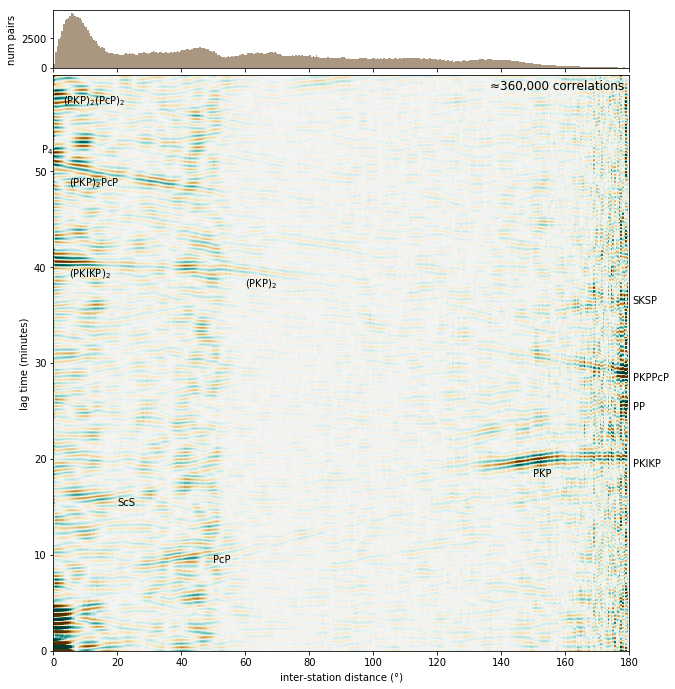

In [11]:
# phase name: distance, lag time in minutes
PHASES = {'PcP': (50, 10),
          'PKP': (150, 19),
          'PKIKP': (181, 20),
          'PP': (181, 26),
          'PKPPcP': (181, 29),
          'SKSP': (181, 37),
          r'(PKP)$_2$': (60, 39),
          r'(PKIKP)$_2$': (5, 40),
          r'(PKP)$_2$PcP': (5, 49.5),
          r'P$_4$': (-4, 53),
          r'(PKP)$_2$(PcP)$_2$': (3, 58),
          'ScS': (20, 16)}

def plot_xcorr_stack(stream, vmax=0.04):    
    stream.sort(['distance'])
    dists = [tr.stats.distance for tr in stream]
    nums = [tr.stats.num for tr in stream]
    ddeg = dists[1] - dists[0]
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_axes([0.05, 0.86, 0.8, 0.08])
    ax1.bar(dists, nums, ddeg, fc='#543005', alpha=0.5)
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_ylabel('num pairs')
    ax2 = fig.add_axes([0.05, 0.05, 0.8, 0.8], sharex=ax1)    
    imdata = []
    for tr in stream:
        N = len(tr)
        imdata.append(0.5 * (tr.data[N // 2:] + tr.data[:N // 2 + 1][::-1]))
    imdata = np.array(imdata).transpose()        
    sr = tr.stats.sampling_rate
    extent = [dists[0] - 0.5 * ddeg, dists[-1] + 0.5 * ddeg, -0.5 / sr / 60, 60 + 0.5 / sr / 60]
    ax2.imshow(imdata, interpolation='nearest', aspect='auto', extent=extent,
              origin='lower', vmin=-vmax, vmax=vmax, cmap='BrBG_r')
    ax2.set_xlabel(u'inter-station distance (°)')
    ax2.set_ylabel('lag time (minutes)')
    ax2.set_yticks(10 * np.arange(6))
    ax2.annotate(u'≈360,000 correlations', (1, 1), (-5, -5), 'axes fraction',
                 'offset points', va='top', ha='right', size='large')
    for k, v in PHASES.items():
        ax2.annotate(k, v, (0, 0), textcoords='offset points',
                     va='top', ha='left', annotation_clip=False)
        
plot_xcorr_stack(xcorrstack)
plt.show()

Please also compare with conclusions presented on the poster.
I want to highlight the following features in the plot:

* Direct waves and the direct P wave cannot be observed ⇒ these are already damped out in the late coda.
* A multitude of core phases can be observed ⇒ late coda consists mainly of waves with low slowness which were reverberated or traveled in the deeper Earth (where attenuation is low).
* There is a zone of low correlation between 50° and 140° inter-station distance. Hypothesis: The late coda consists of waves which are not horizontally scattered. This hypothesis is consistent with recent [beam-forming results](http://dx.doi.org/10.1002/2015GL065108) of the late coda.

To confirm the hypothesis a analysis of the distribution of angles between the station pair and the event as a function of inter-station distance is performed: 

In [12]:
def get_dist_azi(c1, c2):
    r = gps2dist_azimuth(c1[0], c1[1], c2[0], c2[1])
    return r[0] / 1e3 / 111.2, r[1], r[2]

def get_angle(c1, c2, c3):
    """Calulate the angle between coordinates c1, c2, and c3"""
    d1, az1, baz1 = get_dist_azi(c1, c2)
    d2, az2, baz2 = get_dist_azi(c1, c3)
    angle = (az1 - az2) % 360
    if angle > 180:
        angle = 360 - angle
    return angle

distances = []
angles = []

def collect_angles(cevent, cstations):
    total = (len(cstations) * (len(cstations) - 1)) // 2
    for c1, c2 in tqdm(combinations(cstations, 2), total=total):        
        distance, _, _ = get_dist_azi(c1, c2)
        angle = get_angle(cevent, c1, c2)
        distances.append(distance)
        angles.append(angle)

collect_angles(cevent, cstations)

100%|██████████| 363378/363378 [04:12<00:00, 1437.32it/s]


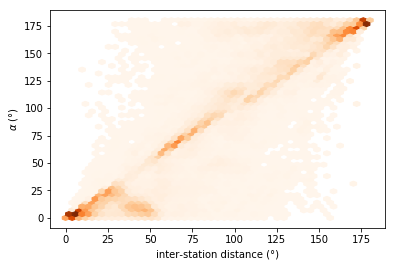

In [13]:
def plot_hexbin(N=46):
    bins = np.linspace(0, 180, N)
    diststack, _ = np.histogram(distances, bins)
    # normalize columns
    C = 1. / diststack[np.digitize(distances, bins)-1]
    plt.hexbin(distances, angles, C=C, reduce_C_function=np.sum, gridsize=N,
               extent=(0, 180, 0, 180), cmap='Oranges', zorder=-1)
    plt.xlabel(u'inter-station distance (°)')
    plt.ylabel(r'$\alpha$' + u' (°)')

plot_hexbin()
plt.show()

Results confirm the hypothesis: The angle is between 45° and 135° for ranges of inter-station distance which show a low correlation in the stack. Inter-station distances where angles dominate that reflect the great circle condition (say smaller than 30° or larger than 150°) show the highest correlation in the stack.

Conclusion: Cross-correlations for which the station pair and the event lay on a great circle are best suited for body wave extraction from the late coda.

It is left as an exercise to adapt the `xcorr_iter` function in that way, that it uses only station pairs full-filling the great circle condition to a given extent. The stack will then also show a higher correlation for medium inter-station distances. The visibility of the PKPPKP phase and other phases will be improved.

## Writing cross-correlations into a HDF5 file

The last section demonstrates how to write the cross-correlation traces to a HDF5 file and how to read them out again for further processing (here again for stacking).

Writing:

* `'xcorr'` indexing is used for saving the file.
* The format is `'H5'` and the append mode `'a'` is used to write the file trace after trace.
* Calculation of the cross-correlations and writing takes 1 hour on my PC.

Reading:
* Of course, ObsPy's read function cannot be used to read the file again, because it is simply to large. Therefore, the `iterh5` function from the `obspyh5` module is used instead. The generated iterator reads the file and returns trace by trace.
* The traces are again passed to the stacking function already defined above.
* Reading and stacking takes 1 hour 10 minutes.

⇒ In this use case it is computationally cheaper to calculate cross-correlations over and over again than to read them out of the HDF5 file.

However, it is beneficial to store processed waveforms in a HDF5 file for other use cases involving more processing steps (e.g. simulations). HDF5 files have several advantages over traditional seismological data formats (e.g. sequential reading of large files as demonstrated below, arbitrary meta data).

In [14]:
obspyh5.set_index('xcorr')
xfname = datadir + 'okhotsk_coda_xcorr.h5'

if os.path.exists(xfname):
    print('File %s exists. To re-calculate cross-correlations delete the file.' % xfname)
else:
    for trx in xcorr_iter(pstream):
        trx.write(xfname, 'H5', mode='a')
    print('Cross-correlations calculated and written to file %s.' % xfname)
    


100%|██████████| 363378/363378 [55:01<00:00, 110.07it/s]

Cross-correlations calculated and written to file data/okhotsk_coda_xcorr.h5.


In [15]:
from obspyh5 import iterh5

obspyh5.set_index('{distance:06.2f}')

xstackfname2 = datadir + 'okhotsk_coda_xcorr_stack2.h5'
if os.path.exists(xstackfname2):
    xcorrstack2 = read(xstackfname2, 'H5')
    print('Loaded file %s. To re-calculate cross-correlation stack delete this file.' % xstackfname2)
else:
    total = (len(pstream) * (len(pstream) - 1)) // 2
    xcorrstack2 = stack_waveforms(tqdm(iterh5(xfname), total=total))
    xcorrstack2.write(xstackfname2, 'H5')
    print('Stacked cross-corelations available in variable xcorrstack2.')

100%|██████████| 363378/363378 [1:20:59<00:00, 74.78it/s]


Stacked cross-corelations available in variable xcorrstack2.
